In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import csv
import random

import sklearn
from sklearn.cluster import KMeans
!pwd
!pip install hmmlearn

## PRIVATE
from copy import deepcopy
N_classes = 3

/content


In [2]:
fpath = "/content/HMMdata.csv"

def file_reader(fpath):
  filep = open(fpath, 'rt')
  reader = csv.reader(filep, delimiter=',')
  return np.array(list(reader))

data = file_reader(fpath)
data = data.astype(np.float64)

(200, 2)


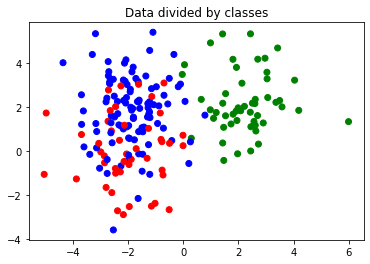

In [3]:
colormap = np.array(['r', 'g', 'b'])
X = np.array(list(map(int, data[:, 0])))
Y = np.array(data[:, 1:])
print(Y.shape)
y1, y2 = np.array(data[:, 1]), np.array(data[:, 2])
plt.scatter(y1, y2, c=colormap[X])
plt.title('Data divided by classes')
plt.show()

In [4]:
from math import pow, sqrt, log
def add_noise_gaussian(eps, delta, sensitivity, size=1):
    # Add 1D noise to data
    # Need to precalculate per data epsilon value
    constant = np.sqrt(2*np.log(1.25/delta))
    sigma = (constant*sensitivity)/eps
    #print('std:', sigma, 'Noise:', np.random.normal(loc=0, scale=sigma))
    if size == 1:
        return np.random.normal(loc=0, scale=sigma, size=size)[0]
    #elif type(size) == int:
    return np.random.normal(loc=0, scale=sigma, size=size)
    #else:

    #elif len(size) > 1:
    #    return np.random.normal(loc=0, sigma=sigma, )

def add_noise(eps, delta, sensitivity, size=1):
    #constant = np.sqrt(2*np.log(1.25/delta))
    sigma = sensitivity/eps
    if size == 1:
        return np.random.laplace(loc=0, scale=sigma, size=size)[0]
    #elif type(size) == int:
    return np.random.laplace(loc=0, scale=sigma, size=size)
    #else:

# Test Noise
x = 1
print(x, x+add_noise(eps=1, delta=0.01, sensitivity=1))
y = np.array([1, 2])
print(y, y+add_noise(eps=1, delta=0.01, sensitivity=1, size=2))
z = np.array([[1, 2], [3, 4]])
print(z, add_noise(eps=1, delta=0.01, sensitivity=1, size=(2, 2)))

1 0.11615906674754883
[1 2] [1.46543387 2.35554352]
[[1 2]
 [3 4]] [[ 1.54355667  0.06571421]
 [-0.00946138 -1.28678647]]


In [5]:
def clip(x, bound):
    den = max(1, np.linalg.norm(x, 1)/bound)
    output = x/den
    #print('Output Norm:', np.linalg.norm(output))
    return output

def clip_gaussian(x, bound):
    den = max(1, np.linalg.norm(x)/bound)
    output = x/den
    #print('Output Norm:', np.linalg.norm(output))
    return output

print(np.linalg.norm(clip(y, 1), 1))

1.0


In [6]:
from math import exp, log
def advanced_composition(eps, delta, iterations):
    delta_prime = delta
    term1=iterations*eps*(exp(eps)-1)
    term2=eps*sqrt(2*iterations*log(1/delta_prime))

    return term1+term2, iterations*delta+delta_prime # eps, delta 

In [7]:
advanced_composition(0.1, 0.005, 24)

(1.8471491588043714, 0.125)

In [8]:
# Privatized K-Means with Gaussian Noise
from copy import deepcopy
class private_KMeans:
    def __init__(self, data, Y_main, X, N_classes, d, tol=0.01, private=False, clip_bound = 4, eps = 1, delta = 1./200, max_iters=10):
        self.N_classes = N_classes # no. of classes
        self.data = data # complete
        self.tol = tol # tolerance for convergence
        self.N = Y.shape[0] # No of samples
        self.Y = deepcopy(Y_main) # data
        self.X = X # labels
        self.clip_bound = clip_bound
        self.d = d # dimensions of the data
        self.private = private # do we want to privatize?
        self.prev_centroids = None
        self.max_iters = max_iters # maximum iterations until convergence
        self.privacy_cost = {'eps':0.0, 'delta':0.0}
        self.privacy_counts = 0
        self.eps = eps
        self.delta = delta
        self.Y_original = deepcopy(self.Y)
        self.priors = np.zeros(self.N_classes)

        # Randomly initialize centroids
        # TODO: Matters a lot
        self.centroids = np.array([np.random.uniform(-self.clip_bound/self.d, self.clip_bound/self.d, self.d) for _ in range(self.N_classes)])
        if self.private:
            for k in range(self.N_classes):
                self.centroids[k, :] = deepcopy(clip_gaussian(self.centroids[k, :], self.clip_bound))
        #self.centroids = Y[np.random.choice(range(X.shape[0]), replace = False, size = self.N_classes), :]
        print('Initialization')
        print(self.centroids)

    

    def run(self):

        if self.private: #PRIVATE
            for n in range(self.N):
                self.Y[n] = deepcopy(clip_gaussian(self.Y[n], self.clip_bound))

            plt.figure()
            plt.scatter(self.Y[:, 0], self.Y[:, 1])
            plt.title('Clipped with norm bound:'+str(self.clip_bound))
            plt.show()

        for iterations in range(self.max_iters):
            votes = []
            for n in range(self.N): # This can be done privately
                distances = []
                for k in range(self.N_classes):
                    distances.append(np.linalg.norm(self.Y[n]-self.centroids[k, :]))
                votes.append(distances.index(min(distances))) # vote on the centroid which data n chooses

            #print(votes)

            # Get new centroids
            self.prev_centroids = deepcopy(self.centroids)

            for k in range(self.N_classes): 
                num = 0.
                den = 0.
                for n in range(self.N):
                    if votes[n] == k:
                        num+=self.Y[n]
                        den+=1
                
                #sensitivity_num = np.sqrt(self.clip_bound)
                sensitivity_num = self.clip_bound
                sensitivity_den = 1
                if self.private: #PRIVATE
                    num += add_noise_gaussian(self.eps, self.delta, sensitivity=sensitivity_num, size=self.d)
                    den += add_noise_gaussian(self.eps, self.delta, sensitivity=sensitivity_den, size=1) # only add positive noise
                    self.privacy_counts+=(1+self.d)
                self.priors[k]=den/self.N
                #privacy_cost['eps']+=2*self.eps
                #privacy_cost['delta']+=2*self.delta
                #print('NUM/DEN', num, den)

                if den > 0:
                    #print('ZERO')
                    self.centroids[k, :] = num/den 
                else:
                    self.centroids[k, :] = num

                if self.private:
                    for k in range(self.N_classes):
                        self.centroids[k, :] = deepcopy(clip_gaussian(self.centroids[k, :], self.clip_bound))
                # else centroids do not change
            #print('Old', self.prev_centroids)
            #print('New', self.centroids)
            # Stopping Condition
            if iterations > 2 and np.linalg.norm(self.centroids-self.prev_centroids) < self.tol:
                print('Iterations Required:', iterations+1)
                print('KMeans Converged')
                break
        if iterations == self.max_iters-1:
            print('Maximum Iterations Done')
            print('Iterations Required:', iterations+1)

        kmeans = KMeans(N_classes).fit(self.Y_original)
        means = kmeans.cluster_centers_

        # Compute priors
        #self.priors = 

        #if self.private:

        #print(means)
        #print(self.centroids)

        if self.private:
            e, d = advanced_composition(self.eps, self.delta, self.privacy_counts)
            print('Total eps/delta', min(e, self.privacy_counts*self.eps), min(d, self.privacy_counts*d))
            print('Total privacy mechanisms', self.privacy_counts)

        plt.figure()
        y1, y2 = np.array(self.data[:, 1]), np.array(self.data[:, 2])
        plt.scatter(y1, y2, c=colormap[X], alpha=0.2)
        plt.scatter(means[:, 0], means[:, 1], s=200, c='m', marker='X', label='In-Built Function')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], s=200, c='c', marker='^', label='Simulation')
        plt.title('KMeans: Data divided by classes')
        plt.legend()
        plt.show()       
          


Initialization
[[-1.24478401  1.92256557]
 [-1.39716474 -1.04232715]
 [-1.23914144  0.96108556]]
Iterations Required: 12
KMeans Converged


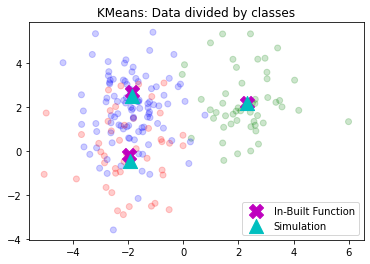

Epsilon: 1
Initialization
[[-0.56247817 -0.74887927]
 [ 0.23253637 -0.16864791]
 [ 0.12008736  1.427385  ]]


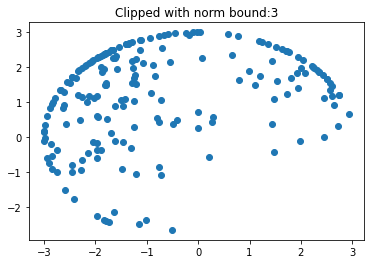

Maximum Iterations Done
Iterations Required: 4
Total eps/delta 36 0.185
Total privacy mechanisms 36


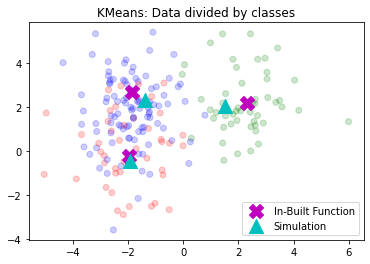

Priors [0.35694213 0.26906244 0.35410245]
Epsilon: 0.5
Initialization
[[-0.06538014  0.9149748 ]
 [ 1.02347829 -1.15867301]
 [-0.05229464 -1.09724407]]


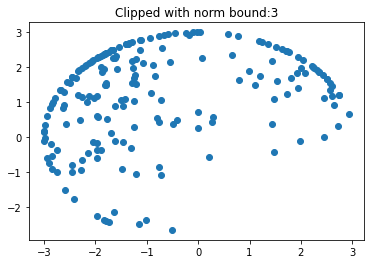

Maximum Iterations Done
Iterations Required: 4
Total eps/delta 18.0 0.185
Total privacy mechanisms 36


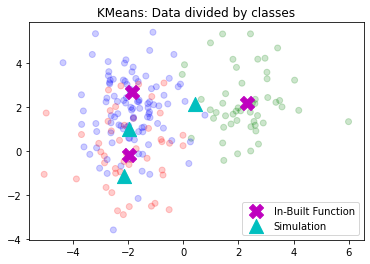

Priors [0.54269454 0.13434085 0.36580847]
Epsilon: 0.2
Initialization
[[-0.34813464 -0.0300924 ]
 [ 0.04076704  0.4141756 ]
 [-0.07562199 -0.02915745]]


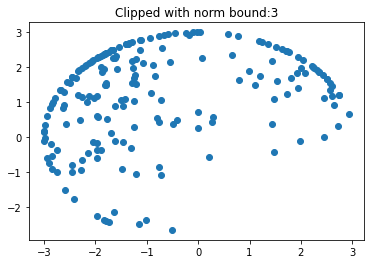

Maximum Iterations Done
Iterations Required: 4
Total eps/delta 5.500396572478174 0.185
Total privacy mechanisms 36


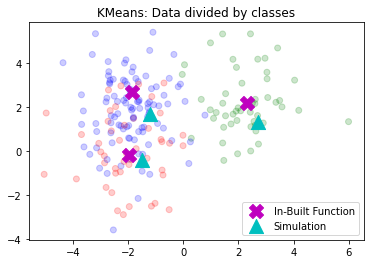

Priors [0.49846973 0.14332653 0.46955442]
Epsilon: 0.1
Initialization
[[ 1.3869463  -1.14495909]
 [ 1.0444986   0.12873593]
 [ 0.36680906  1.35591663]]


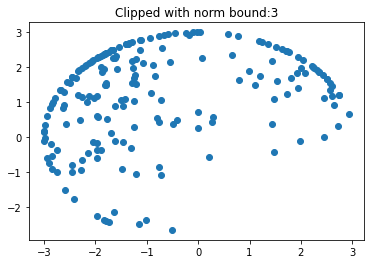

Maximum Iterations Done
Iterations Required: 4
Total eps/delta 2.331763661934807 0.185
Total privacy mechanisms 36


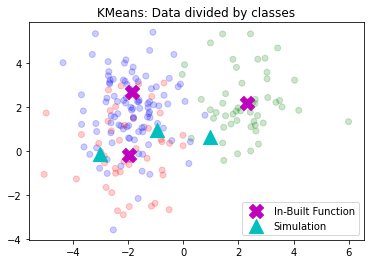

Priors [-0.0115875   0.19023192  0.43453832]


In [9]:
kmeans = private_KMeans(data, Y, X, N_classes=3, d=2, tol=0.00001, private=False, max_iters=20)
kmeans.run()

#print(Y.shape)
#plt.scatter(Y[:, 0], Y[:, 1])
#plt.show()

print('Epsilon: 1')
kmeans = private_KMeans(data, Y, X, N_classes=3, d=2, tol=0.00001, private=True, clip_bound = 3, eps = 1, delta = 1./200, max_iters=4)
kmeans.run()
print('Priors', kmeans.priors)
#plt.scatter(Y[:, 0], Y[:, 1])
#plt.show()

print('Epsilon: 0.5')
kmeans = private_KMeans(data, Y, X, N_classes=3, d=2, tol=0.00001, private=True, clip_bound = 3, eps = 0.5, delta = 1./200, max_iters=4)
kmeans.run()
print('Priors', kmeans.priors)

#plt.scatter(Y[:, 0], Y[:, 1])
#plt.show()

print('Epsilon: 0.2')
kmeans = private_KMeans(data, Y, X, N_classes=3, d=2, tol=0.00001, private=True, clip_bound = 3, eps = 0.2, delta = 1./200, max_iters=4)
kmeans.run()
print('Priors', kmeans.priors)

print('Epsilon: 0.1')
kmeans = private_KMeans(data, Y, X, N_classes=3, d=2, tol=0.00001, private=True, clip_bound = 3, eps = 0.1, delta = 1./200, max_iters=4)
kmeans.run()
print('Priors', kmeans.priors)

In [10]:
# Original GMM 


'''
Expectation Maximization for the Gaussian Mixture Models.

'''

class GMM_EM:
    def __init__(self, N_classes, data, Y_main, X, d=2, max_iters = 5, private=False, clip_bound = 4, eps = 1, delta = 0.01, tol=0.01):
        # K-Means clustering to get centers for mean estimation
        kmeans = KMeans(N_classes).fit(Y)
        labels = kmeans.labels_
        data0 = Y[np.where(labels==0), :][0]
        data1 = Y[np.where(labels==1), :][0]
        data2 = Y[np.where(labels==2), :][0]
        self.max_iters = max_iters
        self.Y = np.array(deepcopy(Y_main), dtype=np.float128)
        self.d = d
        self.tol = tol
        self.N_classes = N_classes
        self.N = Y.shape[0]

        # ----------------------------------------
        # PRIVACY PARAMETERS
        # ----------------------------------------

        self.private = private
        self.privacy_counts = 0
        self.eps = eps
        self.delta = delta
        self.clip_bound = clip_bound

        # ----------------------------------------
        # CLIP DATA
        # ----------------------------------------

        if self.private: # CLIP DATA TO REDUCE SENSITIVITY
            for n in range(self.N):
                self.Y[n] = deepcopy(clip(self.Y[n], self.clip_bound))

        # ----------------------------------------
        # Initialize parameters
        # ----------------------------------------

        if self.private == False: # NON-PRIVATE PERFECT K-Means Initializatino
            self.means = np.array(kmeans.cluster_centers_, dtype=np.float128)
            self.covs = np.array([np.cov(data0.T), np.cov(data1.T), np.cov(data2.T)], dtype=np.float64)
            self.priors = np.array([list(labels).count(label)/len(labels) for label in range(N_classes)],dtype=np.float128)
        else: # Initialize privately
            print('Epsilon: 0.2')
            kmeans_private = private_KMeans(data, Y, X, N_classes=self.N_classes, d=self.d, tol=self.tol, 
                                            private=self.private, clip_bound = self.clip_bound, 
                                            eps = self.eps, delta = self.delta, max_iters=self.max_iters)
            kmeans_private.run()
            #print('Priors', kmeans.priors)
            print('Private KMeans DONE!')
            self.means = np.array(kmeans_private.centroids, dtype=np.float128)
            self.priors = np.array(kmeans_private.priors, dtype=np.float128)
            self.privacy_counts+=kmeans_private.privacy_counts # Add KMeans previous counts

        
            self.covs = np.array([np.eye(self.d)*np.random.random(self.d) for _ in range(self.N_classes)])
            for k in range(self.N_classes):
                diff_k = self.Y-self.means[k, :] 
                self.privacy_counts+=self.d
                samples_k = self.priors[k]*self.N #PRIVATE

                num_cov=(diff_k.T.dot(diff_k))
                if self.private:
                    num_cov+=add_noise(self.eps, self.delta, sensitivity=self.clip_bound**2, size=(self.d, self.d))
                    num_cov=np.abs(num_cov)
                    self.privacy_counts+=(self.d*(self.d+1))/2.

                #self.covs[]
                self.covs[k, :] = num_cov/samples_k # COMPUTE INITIAL COVARIANCE MATRIX


        
    # COMPUTE LOG LIKELIHOOD LOSS
    def log_likelihood_loss(self): # TODO: ASSUMED PRIVATE
        ll = 0.
        for n in range(self.N):
            ll_n = 0.
            for k in range(self.N_classes):
                pi_k, mu_k, sigma_k = self.priors[k], self.means[k, :], self.covs[k, :]
                ll_n += pi_k*self.normal_pdf(self.Y[n], k)*self.priors[k]
            ll+=np.log(ll_n)
        return ll

    def normal_pdf(self, x, k): # done on device so ignore
        mu_k, sigma_k = self.means[k, :], self.covs[k, :]
        try:
            sigma_k_inv = np.float128(np.linalg.inv(sigma_k))
            if np.linalg.det(sigma_k) <= 0:
                print('Problem with determinant')
                self.covs[k, :] = np.eye(self.d)*np.random.random(self.d)
                sigma_k = self.covs[k, :]
                print('Sigma:', sigma_k)
                print('Determinant:', np.linalg.det(sigma_k))
            constant = 1/np.sqrt(((2*np.pi)**len(x))*np.linalg.det(sigma_k))
        except np.linalg.LinAlgError:
            print('Singular Value Error')
            self.covs[k, :] = np.eye(self.d)*np.random.random(self.d)
            sigma_k = self.covs[k, :]
            if np.linalg.det(sigma_k) <= 0:
                print('Problem with determinant')
                self.covs[k, :] = np.eye(self.d)*np.random.random(self.d)
                sigma_k = self.covs[k, :]
                print('Sigma:', sigma_k)
                print('Determinant:', np.linalg.det(sigma_k))
            sigma_k_inv = np.float128(np.linalg.inv(sigma_k)) 
            print('Inv Sigma:', sigma_k_inv)
            constant = np.float128(1/np.sqrt(((2*np.pi)**len(x))*np.linalg.det(sigma_k)))
        #print(np.float128(-0.5*np.dot(np.dot((x-mu_k).T, sigma_k_inv), (x-mu_k))))
        return constant*np.exp(np.float128(-0.5*np.dot(np.dot((x-mu_k).T, sigma_k_inv), (x-mu_k))))

    def compute_gamma(self, n, k): #r_nk value
        # done on device
        num = self.normal_pdf(self.Y[n], k)*self.priors[k]
        den = sum([self.normal_pdf(self.Y[n], k)*self.priors[k] for k in range(self.N_classes)])
        return num/den

    def E_step(self):
        # Calculate gammas
        # can be done on device
        proba = []
        for n in range(self.N):
            proba_k = []
            for k in range(self.N_classes):
                proba_k.append(self.compute_gamma(n, k))
            proba.append(proba_k)

        return np.array(proba, dtype=np.float64)

    def M_step(self, proba):
        samples = np.sum(proba, axis=0)
        if self.private:
            for k in range(N_classes):
                samples[k]+=add_noise(self.eps, self.delta, sensitivity=1, size=1)
                samples[k]=np.abs(samples[k])
                self.privacy_counts+=1

        for k in range(N_classes):
            data = self.Y 
            gammas = np.squeeze(proba[:, k])
            num_mean = (gammas.T.dot(data).flatten())

            if self.private:
                num_mean+=add_noise(self.eps, self.delta, sensitivity=self.clip_bound, size=self.d)
                self.privacy_counts+=self.d

            self.means[k, :] = num_mean/samples[k] 
            mu_k = self.means[k, :]

            diff_k = np.subtract(data, mu_k) 

            num_cov=(diff_k.T.dot(diff_k*gammas[..., np.newaxis]))
            if self.private:
                num_cov+=add_noise(self.eps, self.delta, sensitivity=self.clip_bound**2, size=(self.d, self.d))
                self.privacy_counts+=(self.d*(self.d+1))/2.
                
            self.covs[k, :] = num_cov/samples[k]
            self.priors[k] = samples[k]/np.sum(samples)

    def run_EM(self):

        

        lls = []
        for iterations in range(self.max_iters):
            proba = self.E_step() 
            self.M_step(proba)
            ll = self.log_likelihood_loss()
            print('LL', ll)
            lls.append(ll)

            if len(lls) > 2 and np.abs(lls[-1]-lls[-2]) < self.tol:
                print('GMM Converged!')
                break

        if self.private:
            e, d = advanced_composition(self.eps, self.delta, self.privacy_counts)
            print('Total eps/delta', min(e, self.privacy_counts*self.eps), min(d, self.privacy_counts*d))
        print('No. of Iterations required:', iterations+1)
        plt.figure()
        plt.title('Log Likelihood Loss over iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Log Likehood Loss')
        plt.plot(range(len(lls)), lls)
        plt.show()


            


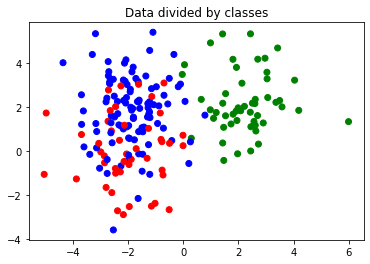

In [11]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(Y)
Y_scaled1 = transformer.transform(Y)

colormap = np.array(['r', 'g', 'b'])
y1, y2 = np.array(Y[:, 0]), np.array(Y[:, 1])
plt.scatter(y1, y2, c=colormap[X])
plt.title('Data divided by classes')
plt.show()

#for y in Y_scaled:
#    print(np.linalg.norm(y))

Epsilon: 0.2
Initialization
[[-0.55174006  0.26584752]
 [ 1.95052192  1.81175844]
 [-0.23436803 -0.66319023]]


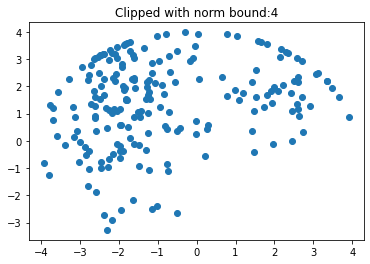

Maximum Iterations Done
Iterations Required: 7
Total eps/delta 126 0.32
Total privacy mechanisms 63


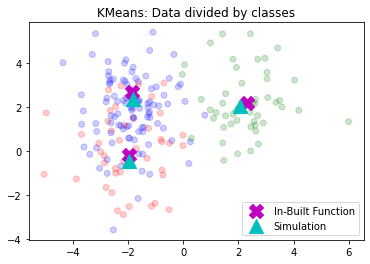

Private KMeans DONE!
LL -901.32357800379183294
LL -900.9067501155166038
LL -901.25016273177259374
LL -898.4902940189756816
LL -888.719285911987619
LL -867.6237663778355491
LL -848.87525584196308653
Total eps/delta 408.0 1.025
No. of Iterations required: 7


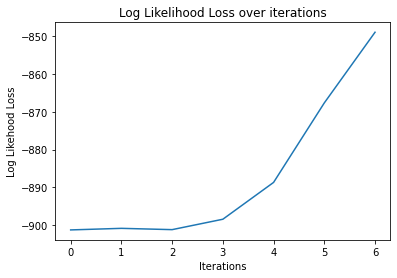

Final Private Parameters
[[-1.75633959  1.59970699]
 [ 1.49946826  1.41518889]
 [-0.84115313  0.06544987]]
[[[ 0.66914595  0.52862392]
  [ 0.65691696  1.17029956]]

 [[ 1.3940502  -0.0810598 ]
  [ 0.34241742  0.59129761]]

 [[ 2.36310236  0.80176789]
  [ 1.34547959  2.71078639]]]
[0.56279108 0.22481057 0.21239836]
Accuracy: 0.42
[0 0 0 0 0 0 0 2 2 1 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 1 2 1
 0 0 0 0 0 0 0 0 2 1 1 0 0 1 1 0 0 0 2 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1
 0 0 2 2 0 1 0 0 1 2 0 0 0 1 0 2 0 1 2 0 0 0 2 2 0 2 1 1 1 1 0 1 0 2 0 1 1
 1 1 1 2 1 1 1 2 0 0 0 0 0 0 2 0 2 2 2 0 1 1 1 1 0 1 1 2 0 2 1 0 0 1 1 0 0
 0 2 2 0 0 2 0 1 0 1 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 1 0 0 1 1 0 0
 0 1 1 2 0 0 2 1 2 0 0 0 0 0 0]
Simualted with eps: 0.2


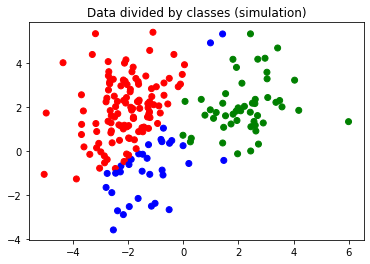

Epsilon: 0.2
Initialization
[[ 1.84938561 -1.30733964]
 [ 0.75890969 -0.3857516 ]
 [-1.75485937  0.9278064 ]]


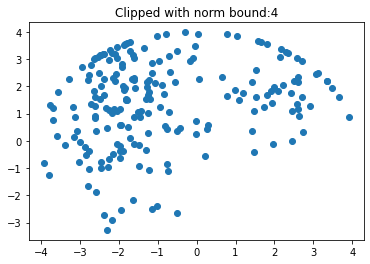

Maximum Iterations Done
Iterations Required: 7
Total eps/delta 63 0.32
Total privacy mechanisms 63


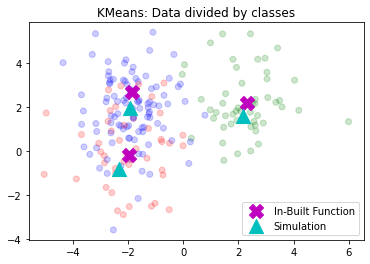

Private KMeans DONE!
LL -857.86687420070343896
Problem with determinant
Sigma: [[0.79531857 0.        ]
 [0.         0.47080636]]
Determinant: 0.37444104180610543
LL -852.7435531905596033
LL -862.9028972506025518
LL -854.2497004352944581
LL -867.27611655227498805
LL -884.180366220894495
LL -904.7636414991064329
Total eps/delta 204.0 1.025
No. of Iterations required: 7


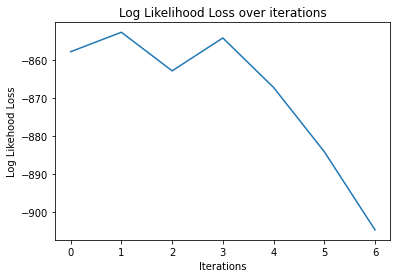

Final Private Parameters
[[ 0.58832843  1.54851529]
 [-0.64715996  1.83098057]
 [-1.54759612  0.74390152]]
[[[ 3.03635099  0.69355062]
  [ 0.15198739  0.7700304 ]]

 [[ 2.55885193 -0.50459356]
  [-0.72675228  0.31871201]]

 [[ 1.52887977  0.82333621]
  [ 0.85079421  3.02508463]]]
[0.21051573 0.28310031 0.50638396]
Accuracy: 0.365
[2 2 1 2 1 2 1 2 2 0 2 2 0 2 2 2 2 1 1 2 2 1 1 1 2 2 2 2 1 2 2 2 1 2 0 2 2
 2 2 1 2 1 1 1 2 2 0 0 1 2 0 0 2 1 2 2 2 2 0 0 2 1 1 1 2 2 2 0 0 1 2 0 2 0
 1 2 2 2 1 1 2 2 1 2 1 1 2 1 2 2 2 0 2 2 1 1 2 2 2 2 0 0 1 0 1 0 2 2 1 1 0
 0 0 0 2 0 0 0 2 2 1 2 1 2 1 2 2 2 2 2 2 1 0 0 0 2 0 0 2 2 2 0 1 2 0 2 2 1
 2 2 2 1 2 2 2 0 1 1 2 2 2 1 2 2 1 1 2 1 2 2 2 2 2 2 2 1 2 2 1 1 2 0 1 2 1
 2 1 0 2 2 2 2 0 0 1 1 2 2 1 2]
Simualted with eps: 0.2


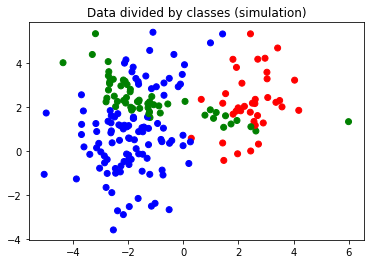

Epsilon: 0.2
Initialization
[[ 0.1063056  -1.83597108]
 [-1.49453041 -1.99985736]
 [ 0.60762341  1.29886008]]


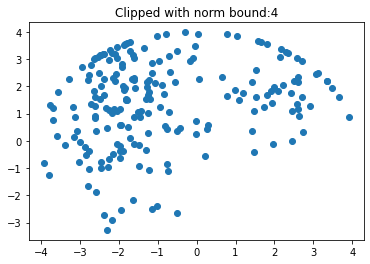

Maximum Iterations Done
Iterations Required: 7
Total eps/delta 31.5 0.32
Total privacy mechanisms 63


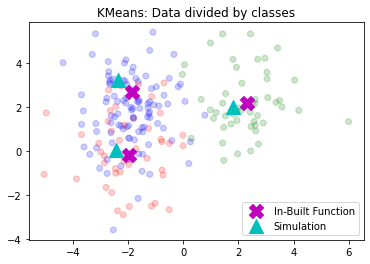

Private KMeans DONE!
LL -914.29426828438548436
Problem with determinant
Sigma: [[0.52610958 0.        ]
 [0.         0.94125895]]
Determinant: 0.49520534828411483
LL -908.85489258206131047
LL -754.3490547240170721
LL -951.41213447489607874
Problem with determinant
Sigma: [[0.28219077 0.        ]
 [0.         0.95368412]]
Determinant: 0.2691208536656653
Problem with determinant
Sigma: [[0.51296486 0.        ]
 [0.         0.75928795]]
Determinant: 0.3894880366418501
LL -1067.2384218261159394
Problem with determinant
Sigma: [[0.63936389 0.        ]
 [0.         0.91906067]]
Determinant: 0.5876142023845843
Problem with determinant
Sigma: [[0.91319461 0.        ]
 [0.         0.59652339]]
Determinant: 0.5447419397809484
LL -918.37358105874111863
LL -817.5373992198279295
Total eps/delta 89.4166849461788 1.025
No. of Iterations required: 7


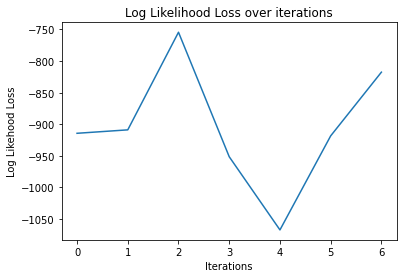

Final Private Parameters
[[ 0.30678902  2.7134573 ]
 [-1.99494737  0.88496226]
 [ 2.13425192  1.4140788 ]]
[[[ 2.25488618  0.47637286]
  [ 3.14903532  0.96778623]]

 [[ 0.48599014 -0.67330639]
  [ 0.54563703  2.5787727 ]]

 [[ 2.01308007  0.98231956]
  [-0.47327142  1.8825304 ]]]
[0.14802917 0.67715027 0.17482056]
Accuracy: 0.085
[0 0 0 1 1 1 1 1 0 2 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 2
 0 1 1 0 1 1 1 0 0 2 2 1 1 2 2 0 1 1 1 0 0 0 2 0 0 2 1 1 0 0 2 2 2 0 2 0 2
 1 1 1 1 1 2 0 0 2 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 2 2 2 2 1 2 0 1 1 2 2
 2 2 2 1 0 2 2 1 0 0 0 0 0 1 0 0 2 1 1 0 2 2 2 2 0 2 2 1 0 1 2 1 0 2 2 1 0
 0 2 1 1 1 1 1 2 1 2 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 2 0 1 2 0 0 1
 1 2 2 1 1 0 1 2 2 1 1 0 0 1 1]
Simualted with eps: 0.2


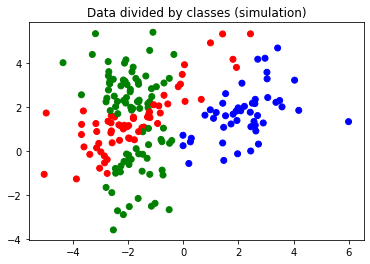

Epsilon: 0.2
Initialization
[[ 1.81334377 -0.45344425]
 [ 0.39607211 -1.2908576 ]
 [-0.73620401  0.88594084]]


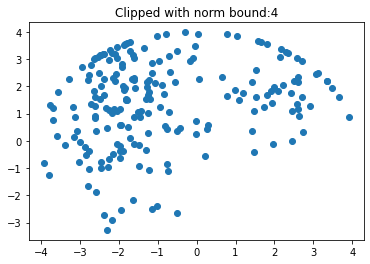

Maximum Iterations Done
Iterations Required: 7
Total eps/delta 7.957219578690685 0.32
Total privacy mechanisms 63


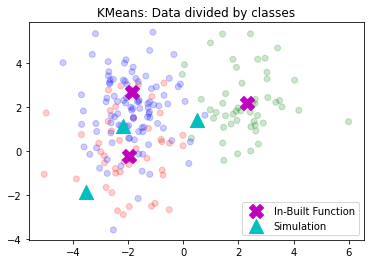

Private KMeans DONE!
Problem with determinant
Sigma: [[0.64322898 0.        ]
 [0.         0.19721479]]
Determinant: 0.1268542712116589
LL -914.07573206095020646
Problem with determinant
Sigma: [[0.6527539  0.        ]
 [0.         0.18311051]]
Determinant: 0.11952609878070615
Problem with determinant
Sigma: [[0.32381575 0.        ]
 [0.         0.44598698]]
Determinant: 0.1444176078592885
LL -921.5790548041940838
Problem with determinant
Sigma: [[0.51611856 0.        ]
 [0.         0.97405434]]
Determinant: 0.5027275234271535
LL -959.18934316846220245
Problem with determinant
Sigma: [[0.28882656 0.        ]
 [0.         0.17308072]]
Determinant: 0.04999031088333569
LL -1048.4935934207755105
LL -956.1217409229768176
Problem with determinant
Sigma: [[0.61312932 0.        ]
 [0.         0.77919189]]
Determinant: 0.4777453888273828
Problem with determinant
Sigma: [[0.71397687 0.        ]
 [0.         0.20388656]]
Determinant: 0.1455702883263866
LL -852.11838334508970005
Problem with deter

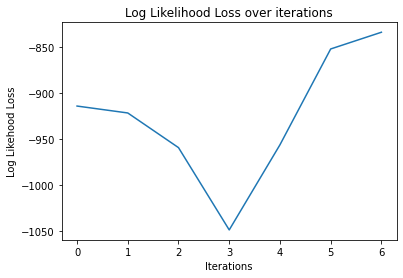

Final Private Parameters
[[-2.47991665 -0.06199077]
 [-0.55049044  3.0739202 ]
 [-0.79228573  1.50705205]]
[[[-0.67915099  5.04454026]
  [-2.61334857  1.1118722 ]]

 [[ 0.31121231  0.        ]
  [ 0.          0.30125146]]

 [[ 3.09377782 -0.13987314]
  [-0.16374266  2.15995496]]]
[0.23144414 0.06791871 0.70063715]
Accuracy: 0.52
[2 2 2 1 2 2 2 0 0 0 0 2 0 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 1 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 0 2 0 2 2 2 0 2 2 2 2 2 0 0 0 2 2 2 2 2 2 1 0 2 2 2 2 0 0
 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 2 0 0 0 2 2 0 0 2 2 0 2 0 0 2 0 2 0 2 2 0
 0 2 0 2 0 0 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 0 2 0 2 0 2 0 0 2 0 2 0 2 2 2 2
 2 2 0 2 2 0 2 0 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 0 2 2 2 0 0 2 2 2 0 2 2 2
 2 2 0 2 1 2 0 0 2 2 2 2 2 2 1]
Simualted with eps: 0.2


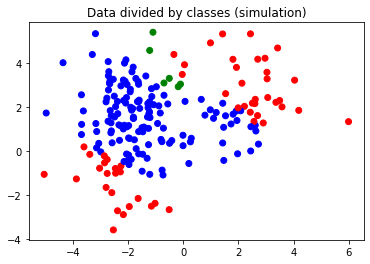

In [12]:


gmm_em_private = GMM_EM(N_classes, data, Y, X, d=2, max_iters = 7, private=True, clip_bound = 4, eps = 2, delta = 1./200, tol=0.0001)
gmm_em_private.run_EM()
print('Final Private Parameters')
print(gmm_em_private.means)
print(gmm_em_private.covs)
print(gmm_em_private.priors)
proba_sim_private = gmm_em_private.E_step()
proba_labels_sim_private = np.argmax(proba_sim_private, 1)
print('Accuracy:', np.mean(np.argmax(proba_sim_private, 1) ==  X))

# Private

#print(proba_sim_private)
print(np.argmax(proba_sim_private, 1))

print('Simualted with eps:', 0.2)
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim_private)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

gmm_em_private = GMM_EM(N_classes, data, Y, X, d=2, max_iters = 7, private=True, clip_bound = 4, eps = 1, delta = 1./200, tol=0.0001)
gmm_em_private.run_EM()
print('Final Private Parameters')
print(gmm_em_private.means)
print(gmm_em_private.covs)
print(gmm_em_private.priors)
proba_sim_private = gmm_em_private.E_step()
proba_labels_sim_private = np.argmax(proba_sim_private, 1)
print('Accuracy:', np.mean(np.argmax(proba_sim_private, 1) ==  X))

# Private

#print(proba_sim_private)
print(np.argmax(proba_sim_private, 1))

print('Simualted with eps:', 0.2)
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim_private)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

gmm_em_private = GMM_EM(N_classes, data, Y, X, d=2, max_iters = 7, private=True, clip_bound = 4, eps = 0.5, delta = 1./200, tol=0.0001)
gmm_em_private.run_EM()
print('Final Private Parameters')
print(gmm_em_private.means)
print(gmm_em_private.covs)
print(gmm_em_private.priors)
proba_sim_private = gmm_em_private.E_step()
proba_labels_sim_private = np.argmax(proba_sim_private, 1)
print('Accuracy:', np.mean(np.argmax(proba_sim_private, 1) ==  X))

# Private

#print(proba_sim_private)
print(np.argmax(proba_sim_private, 1))

print('Simualted with eps:', 0.2)
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim_private)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

gmm_em_private = GMM_EM(N_classes, data, Y, X, d=2, max_iters = 7, private=True, clip_bound = 4, eps = 0.2, delta = 1./200, tol=0.0001)
gmm_em_private.run_EM()
print('Final Private Parameters')
print(gmm_em_private.means)
print(gmm_em_private.covs)
print(gmm_em_private.priors)
proba_sim_private = gmm_em_private.E_step()
proba_labels_sim_private = np.argmax(proba_sim_private, 1)
print('Accuracy:', np.mean(np.argmax(proba_sim_private, 1) ==  X))

# Private

#print(proba_sim_private)
print(np.argmax(proba_sim_private, 1))

print('Simualted with eps:', 0.2)
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim_private)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

[0.35878272 0.26732638 0.3738909 ]
LL -931.95711790758840004
Singular Value Error
Inv Sigma: [[1.38675878 0.        ]
 [0.         1.73343744]]
LL -923.20314677538954157
LL -920.45262890812541284
LL -919.2792673026974026
LL -918.70868251144320565
LL -918.42125690303711266
Singular Value Error
Inv Sigma: [[ 2.49273061  0.        ]
 [ 0.         64.08786603]]
LL -918.27313097093916994
LL -918.1943485923955303
LL -918.15110838091621215
Problem with determinant
Sigma: [[0.36204136 0.        ]
 [0.         0.771506  ]]
Determinant: 0.27931708484947165
LL inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


LL -918.1126958239974744
LL -918.10445566724759636
LL -918.0995472385699979
LL -918.09659283465874713
Singular Value Error
Inv Sigma: [[7.87746798 0.        ]
 [0.         1.13310561]]
LL -918.09480784843274037
LL -918.09373634026798844
LL -918.0931078344889035
Problem with determinant
Sigma: [[0.68685655 0.        ]
 [0.         0.08030462]]
Determinant: 0.05515775633347249
LL inf
LL -918.09258665757539747
LL -918.0925283883150755
GMM Converged!
No. of Iterations required: 20


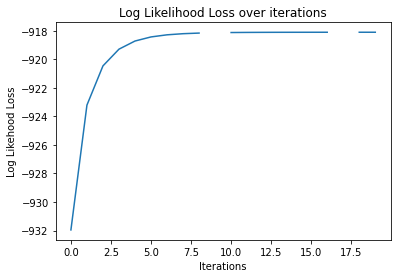

Final Parameters
[[ 0.68334292  1.95707539]
 [-2.07512147  1.15344167]
 [-0.59740094 -2.63888463]]
[[[ 4.77115070e+00  6.19848266e-01]
  [ 6.19848266e-01  2.05410018e+00]]

 [[ 6.10344416e-01 -4.05846594e-02]
  [-4.05846594e-02  3.45298195e+00]]

 [[ 4.91379905e-02 -1.34283765e-02]
  [-1.34283765e-02  4.29920432e-03]]]
[4.38659301e-01 5.61340699e-01 4.91102381e-60]
Accuracy: 0.035


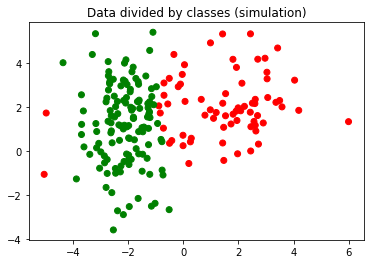

In [13]:
# Try with a random initialization, Gives poor results & takes way longer
N_classes = 3
gmm_em = GMM_EM(N_classes, data, Y, X, d=2, max_iters=100, tol=0.0001)
n_classes, d = 3, 2
P = np.random.random(n_classes)
gmm_em.priors = P/np.sum(P)
#gmm_em.priors = np.array([1./n_classes for _ in range(n_classes)])
print(gmm_em.priors)
gmm_em.means = np.random.uniform(-20, 20, n_classes*d).reshape(n_classes, d)
gmm_em.covs = np.array([np.eye(d)*np.random.random(d) for _ in range(n_classes)])
#print(np.eye(d)*np.random.uniform(1, 10, 2))
gmm_em.run_EM()
print('Final Parameters')
print(gmm_em.means)
print(gmm_em.covs)
print(gmm_em.priors)
proba_sim = gmm_em.E_step()
proba_labels_sim = np.argmax(proba_sim, 1)
print('Accuracy:', np.mean(np.argmax(proba_sim, 1) ==  X))

colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

LL -993.9772185363634427
LL -993.0483306074017649
LL -992.68052304930599183
LL -992.50388480319679246
LL -992.40791755477617186
LL -992.3507172683646179
LL -992.31391908194723683
No. of Iterations required: 7


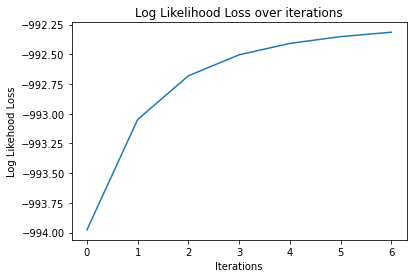

Final Parameters
[[-1.80285923  2.42265228]
 [ 2.19170049  2.14718609]
 [-2.07100084  0.08733736]]
[[[ 0.86604919 -0.08763105]
  [-0.08763105  1.42512914]]

 [[ 1.22713154  0.1319484 ]
  [ 0.1319484   1.86720372]]

 [[ 1.05746326 -0.0200051 ]
  [-0.0200051   2.26849957]]]
[0.37896578 0.25905848 0.36197574]
0.465
True Parameters
[[ 2.19853835  2.1476146 ]
 [-2.0593749   0.07402729]
 [-1.80933359  2.44118961]]
[[[ 1.21504424  0.13171905]
  [ 0.13171905  1.86544026]]

 [[ 1.06034715 -0.00834307]
  [-0.00834307  2.21823842]]

 [[ 0.87430621 -0.07953249]
  [-0.07953249  1.39772044]]]
[0.25824606 0.36305577 0.37869817]
True
Iters Required 6
0.34
In-Built


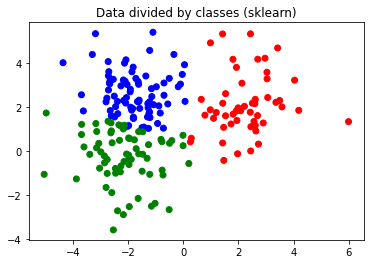

Simulation


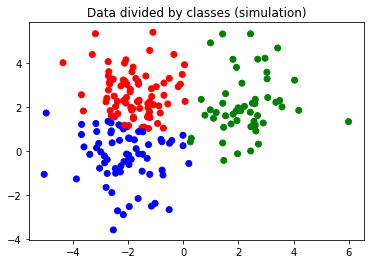

18
Privacy Budget: 81.0 0.09
Problem with determinant
Sigma: [[0.95249199 0.        ]
 [0.         0.70214127]]
Determinant: 0.6687839374232468
Problem with determinant
Sigma: [[0.1365152  0.        ]
 [0.         0.86984551]]
Determinant: 0.11874713068743417
0.605
Simulation Private


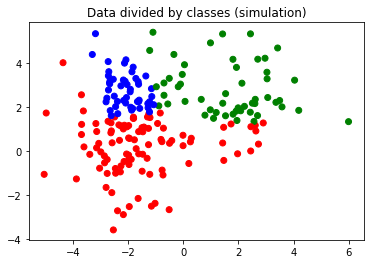

In [14]:
N_classes = 3
gmm_em = GMM_EM(N_classes, data, Y, X, d=2, max_iters=7)
gmm_em.run_EM()
print('Final Parameters')
print(gmm_em.means)
print(gmm_em.covs)
print(gmm_em.priors)
proba_sim = gmm_em.E_step()
proba_labels_sim = np.argmax(proba_sim, 1)
print(np.mean(np.argmax(proba_sim, 1) ==  X))



print('True Parameters')
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3)
gm = gm.fit(Y)
print(gm.means_)         
print(gm.covariances_)
print(gm.weights_)
print(gm.converged_)
print('Iters Required', gm.n_iter_)
proba_sklearn = gm.predict_proba(Y)
proba_labels_sklearn = np.argmax(proba_sklearn, 1)
print(np.mean(np.argmax(proba_sklearn, 1) ==  X))

# In-Built
print('In-Built')
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sklearn)))

plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (sklearn)')
plt.show()

# True simulation
print('Simulation')
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

eps_model = 4.5
# Private Last Model
counts = 0
b = 3
for k in range(3):
    gmm_em.means[k, :] = clip_gaussian(gmm_em.means[k, :], b)
    gmm_em.covs[k, :] = clip_gaussian(gmm_em.covs[k, :], b**2)
    gmm_em.means[k, :]+=add_noise(eps_model, 1./200, sensitivity=b, size=2)
    gmm_em.priors[k]+=(add_noise(eps_model, 1./200, sensitivity=1, size=1))
    gmm_em.covs[k, :]+=(add_noise(eps_model, 1./200, sensitivity=b**2, size=(2, 2)))
    counts+=6
gmm_em.priors = np.abs(gmm_em.priors)
#gmm_em.covs = np.abs(gmm_em.covs)
gmm_em.priors/=np.sum(gmm_em.priors)
print(counts)
eps1, delta1 = advanced_composition(eps_model, 1./200, counts)
print('Privacy Budget:', min(counts*eps_model, eps1), min(1./200*counts, delta1))

proba_sim_private = gmm_em.E_step()
proba_labels_sim_private = np.argmax(proba_sim_private, 1)
print(np.mean(np.argmax(proba_sim_private, 1) ==  X))

# True simulation
print('Simulation Private')
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim_private)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()